In [1]:
from pathlib import Path
import decoupler as dc
import numpy as np
import plotnine as pn
import scanpy as sc
import pandas as pd
import partipy as pt
import sys
import os

sys.path.insert(0, os.path.abspath(".."))
from ..utils.data_utils import load_ms_data

data_dir = Path("..") / "data"
adata = load_ms_data(data_dir=data_dir)
adata = adata[adata.obs["celltype"] == "MG", :].copy()
adata.var = adata.var.set_index("index") # use gene names instead of ENSEMBL ID
adata

File already exists, skipping: ../data/sn_atlas.h5ad
File already exists, skipping: ../data/GSE279183_RAW.tar
Extraction directory already exists, skipping: ../data/GSE279183_extracted


/home/pschaefer/miniforge3/envs/partipy_3/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
/home/pschaefer/miniforge3/envs/partipy_3/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 9239 × 32115
    obs: 'patient_id', 'sample_id', 'condition', 'lesion_type', 'age', 'sex', 'rin', 'pmi_hrs', 'duration_y', 'ms_class', 'cause_death', 'batch_sn', 'celltype', 'subtype'
    var: 'highly_variable', 'highly_variable_nbatches', 'gene_name', 'gene_type'
    obsm: 'X_pca', 'X_umap'

In [2]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
sc.pp.pca(adata, mask_var="highly_variable")
adata.layers["z_scaled"]= sc.pp.scale(adata.X, max_value=10)

100%|██████████| 20/20 [01:44<00:00,  5.24s/it]


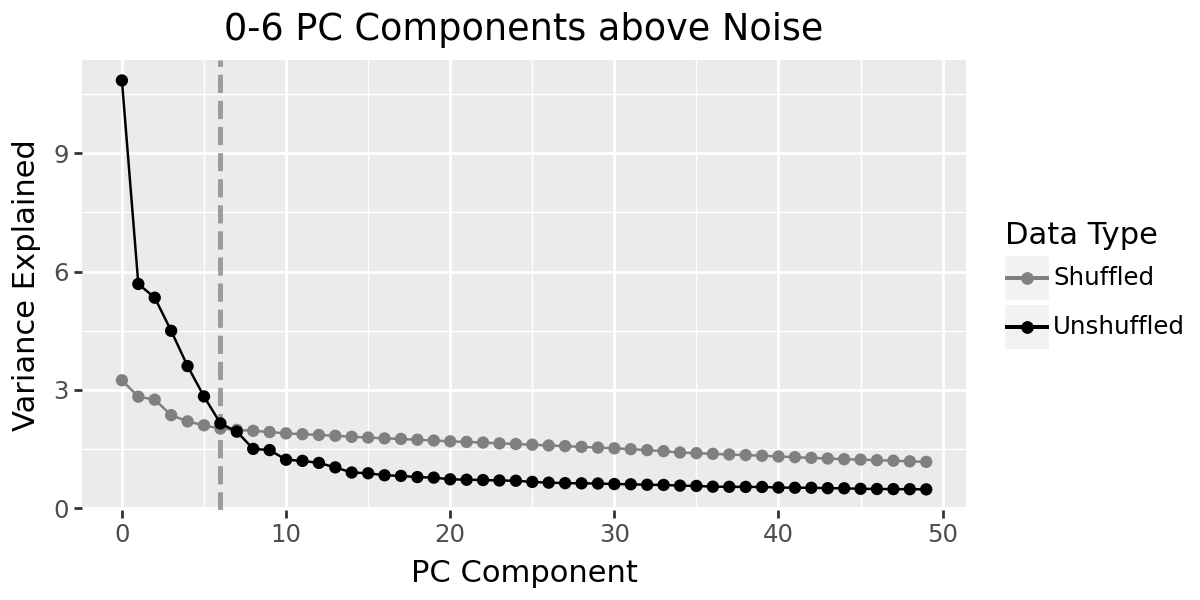

In [3]:
pt.compute_shuffled_pca(adata, mask_var="highly_variable", n_shuffle=20)
pt.plot_shuffled_pca(adata)

In [4]:
pt.set_obsm(adata=adata, obsm_key="X_pca", n_dimensions=7)

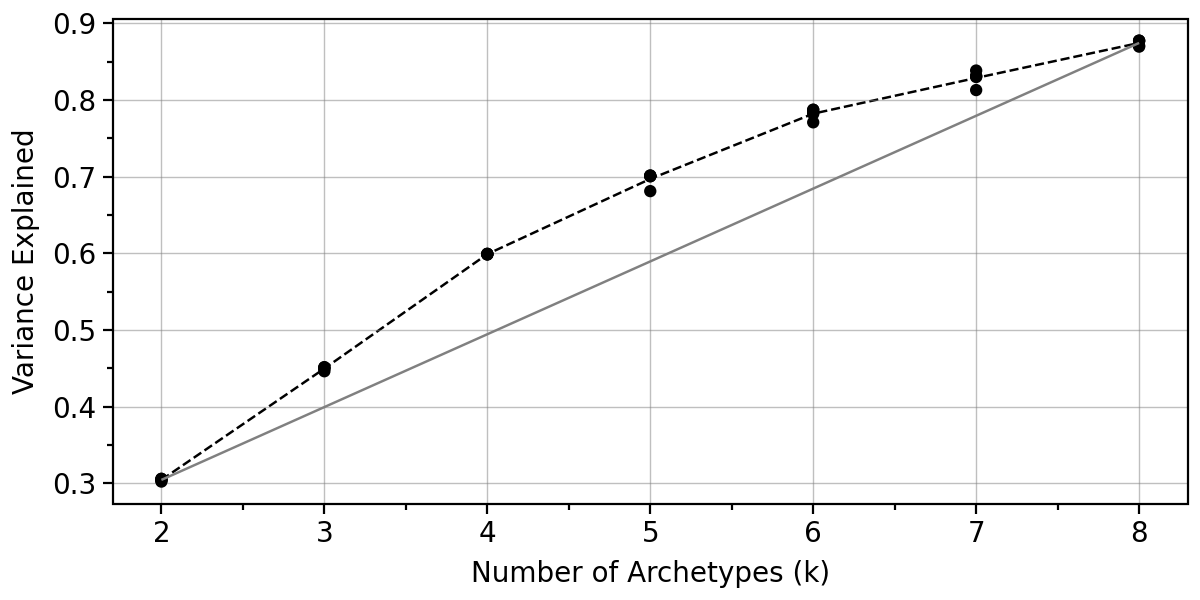

In [5]:
pt.compute_selection_metrics(adata=adata, min_k=2, max_k=8)
pt.plot_var_explained(adata)

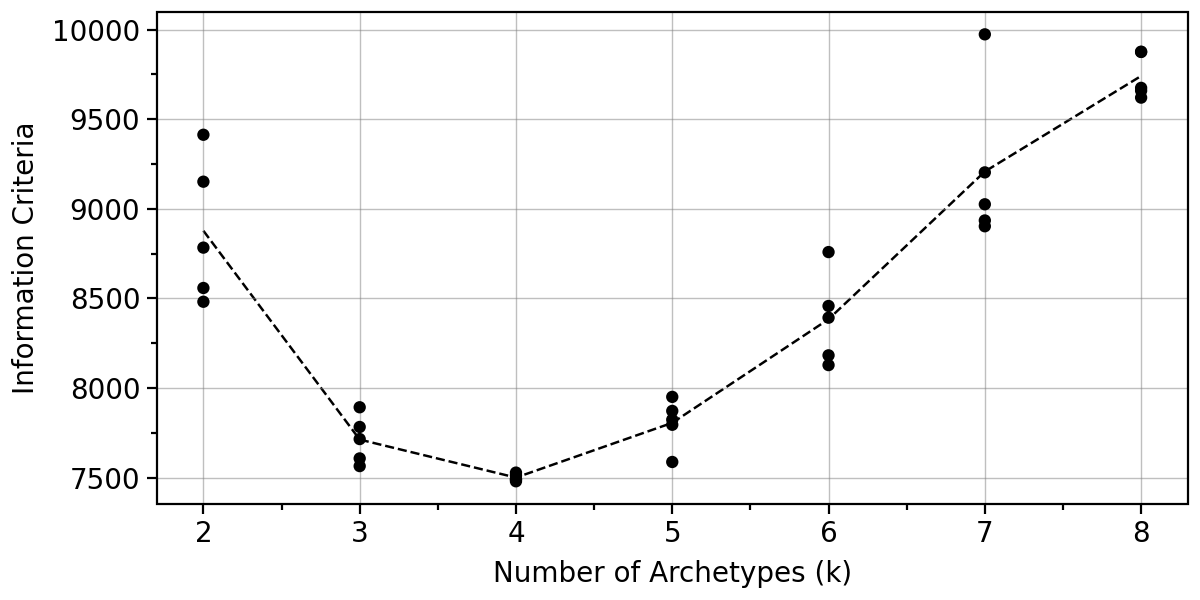

In [6]:
pt.plot_IC(adata)

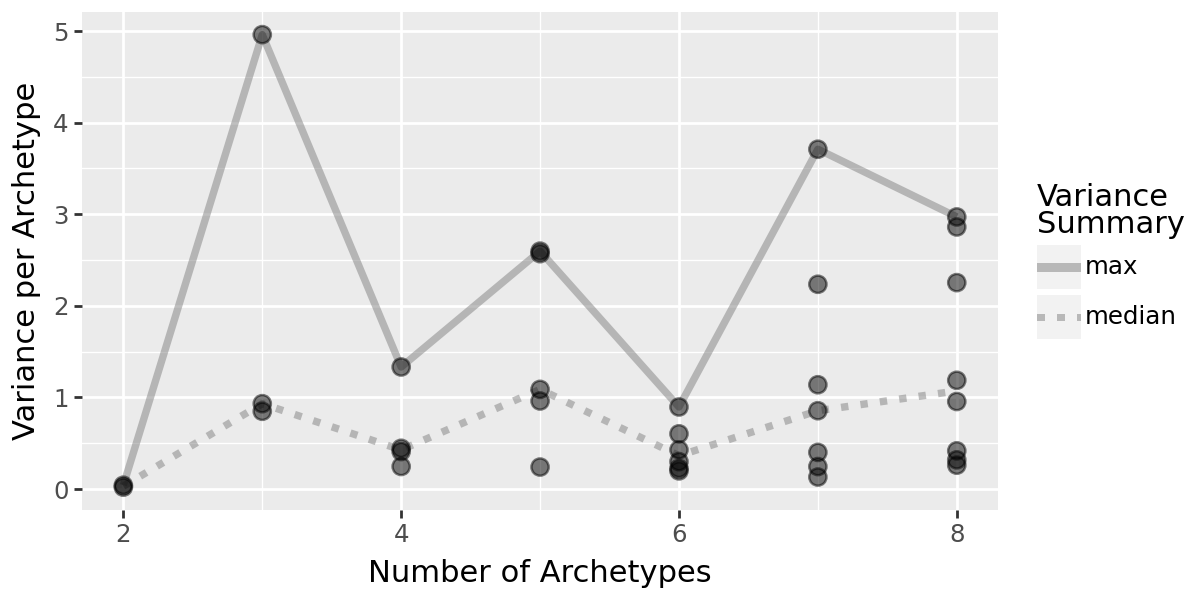

In [7]:
pt.compute_bootstrap_variance(adata=adata, n_bootstrap=50, n_archetypes_list=range(2, 9))
pt.plot_bootstrap_variance(adata)

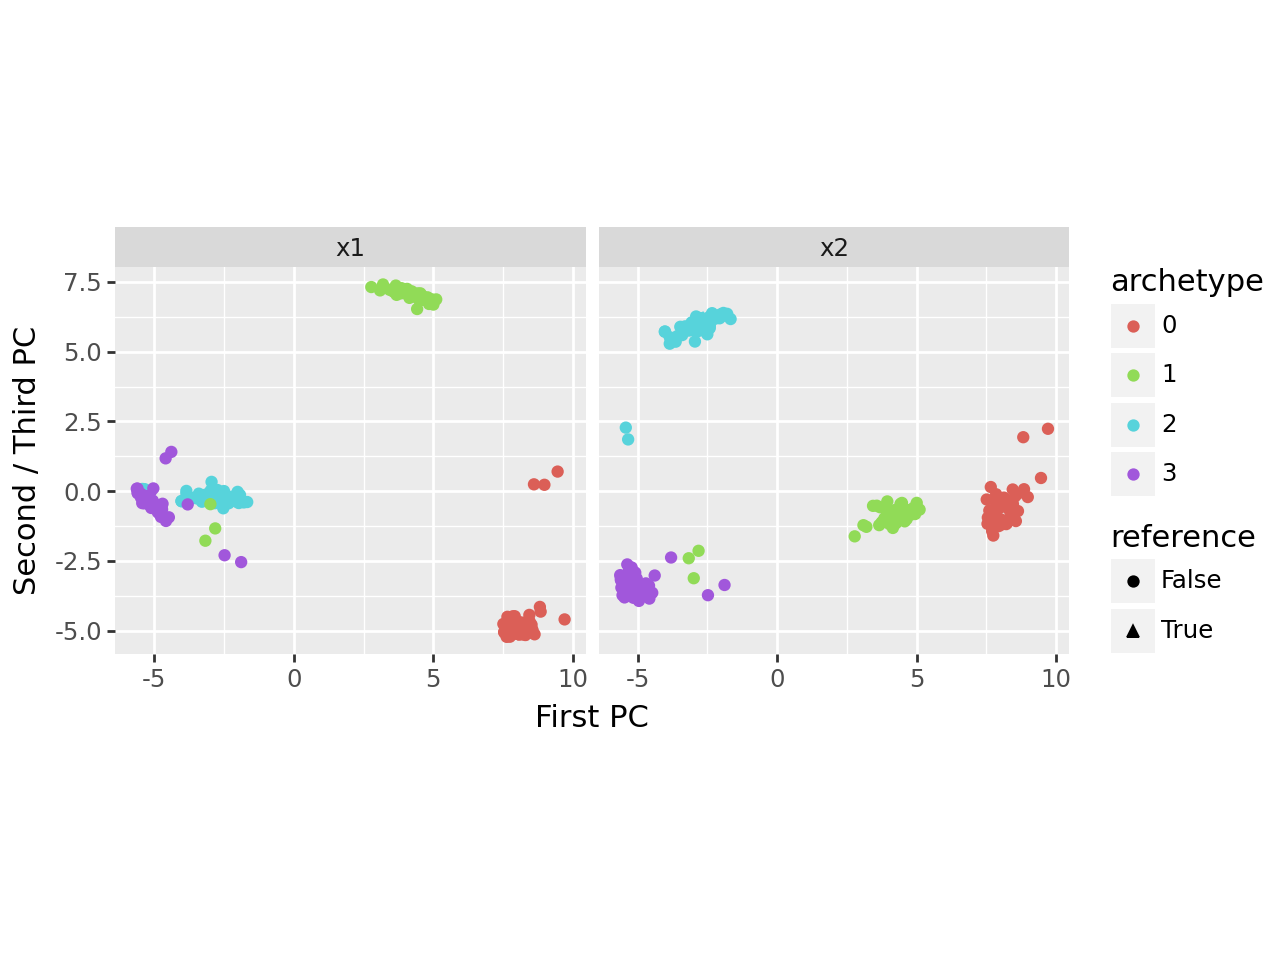

In [ ]:
pt.plot_bootstrap_2D(adata, n_archetypes=4)

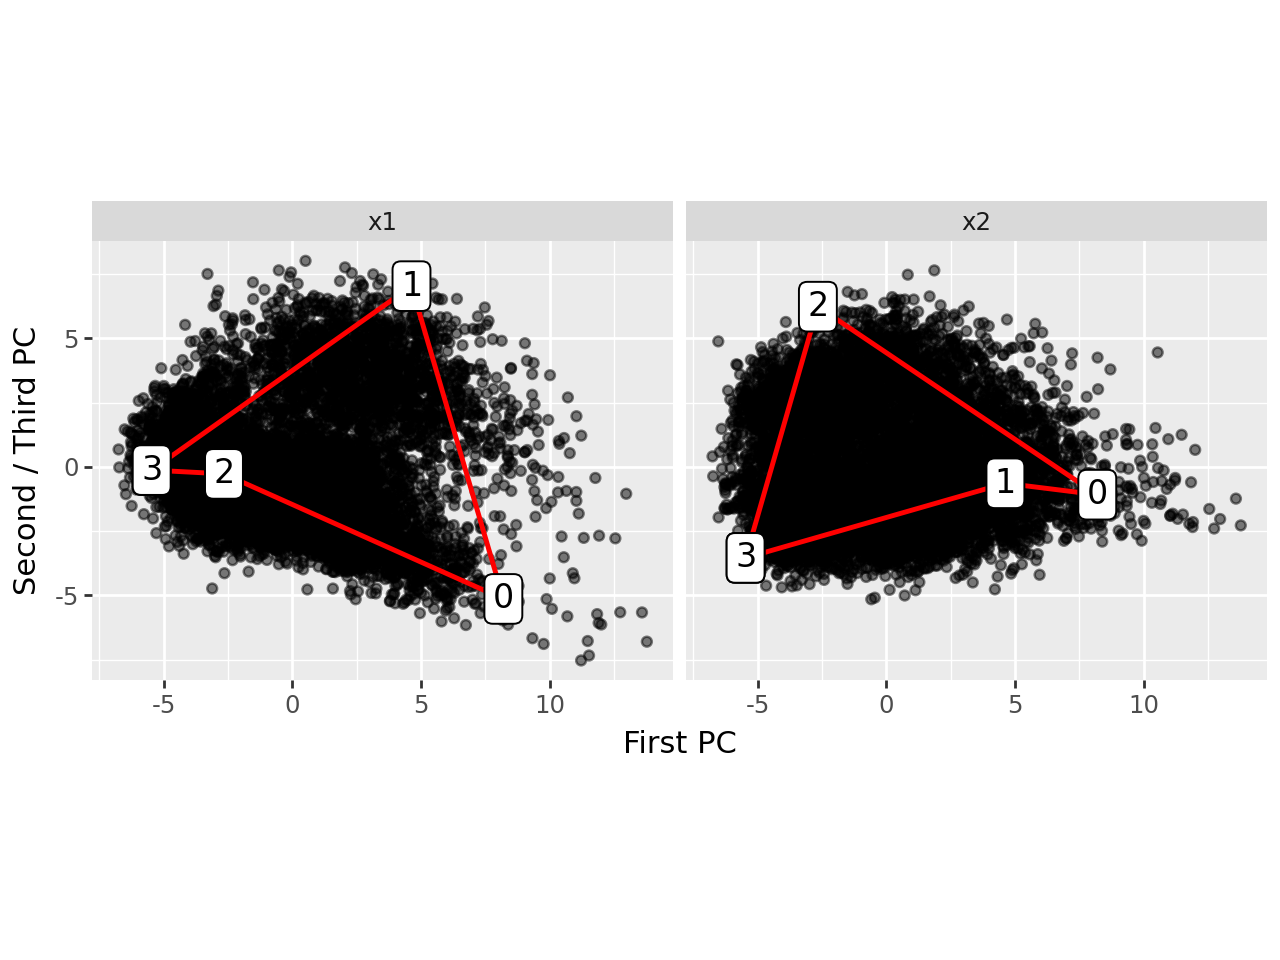

In [ ]:
pt.compute_archetypes(adata, n_archetypes=4, archetypes_only=False)
    
pt.plot_archetypes_2D(adata=adata, alpha=0.5)

In [10]:
pt.compute_archetype_weights(adata=adata, mode="automatic")
archetype_expression = pt.compute_archetype_expression(adata=adata, layer="z_scaled")

Applied length scale is 3.83.


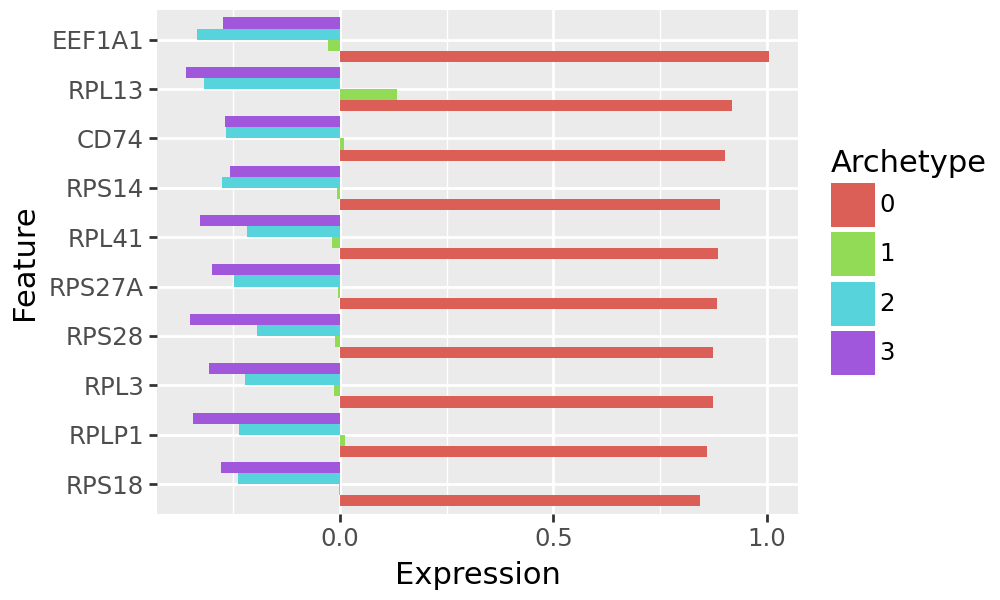

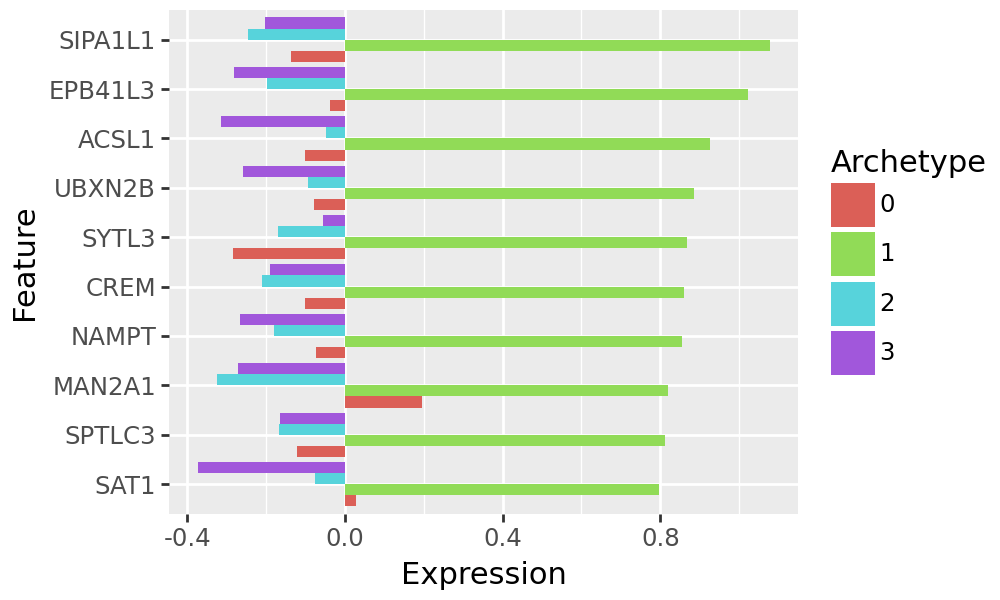

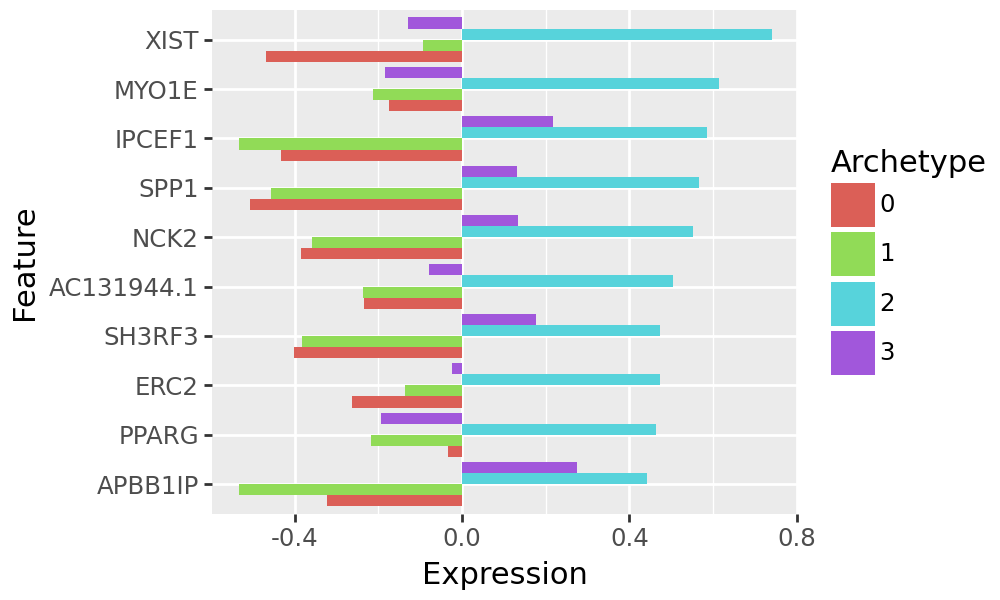

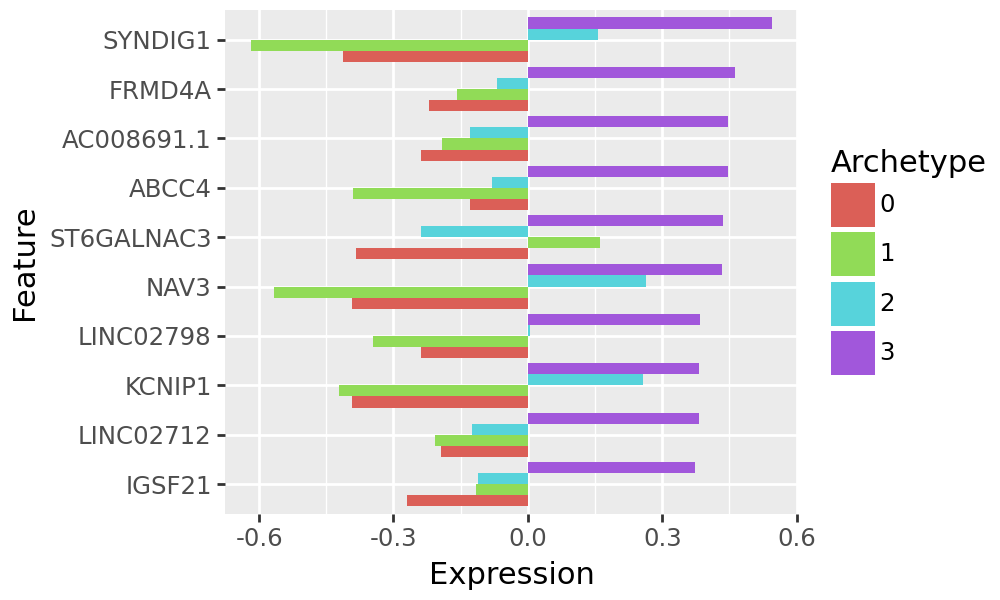

In [11]:
for arch_idx in range(adata.uns["AA_results"]["Z"].shape[0]):
    p = pt.plot_top_genes(archetype_expression=archetype_expression, arch_idx=arch_idx, top_n=10) + pn.theme(figure_size=(5, 3))
    p.show()

In [12]:
db = dc.op.hallmark(organism="human")
acts_ulm_est, acts_ulm_est_p = dc.mt.ulm(data=archetype_expression,
                                         net=db,
                                         verbose=False)

acts_ulm_est.iloc[:4, :4]

,ADIPOGENESIS,ALLOGRAFT_REJECTION,ANDROGEN_RESPONSE,ANGIOGENESIS
0,6.852313,9.504870,4.858731,-1.490126
1,3.290421,2.260249,3.353353,1.822716
2,3.863061,-0.158642,5.170045,2.630249
3,-7.275836,-5.583747,-6.593309,-0.966410


In [13]:
top_processes = pt.extract_enriched_processes(est=acts_ulm_est, 
                                              pval=acts_ulm_est_p, 
                                              order="desc", 
                                              n=10,
                                              p_threshold=0.10)

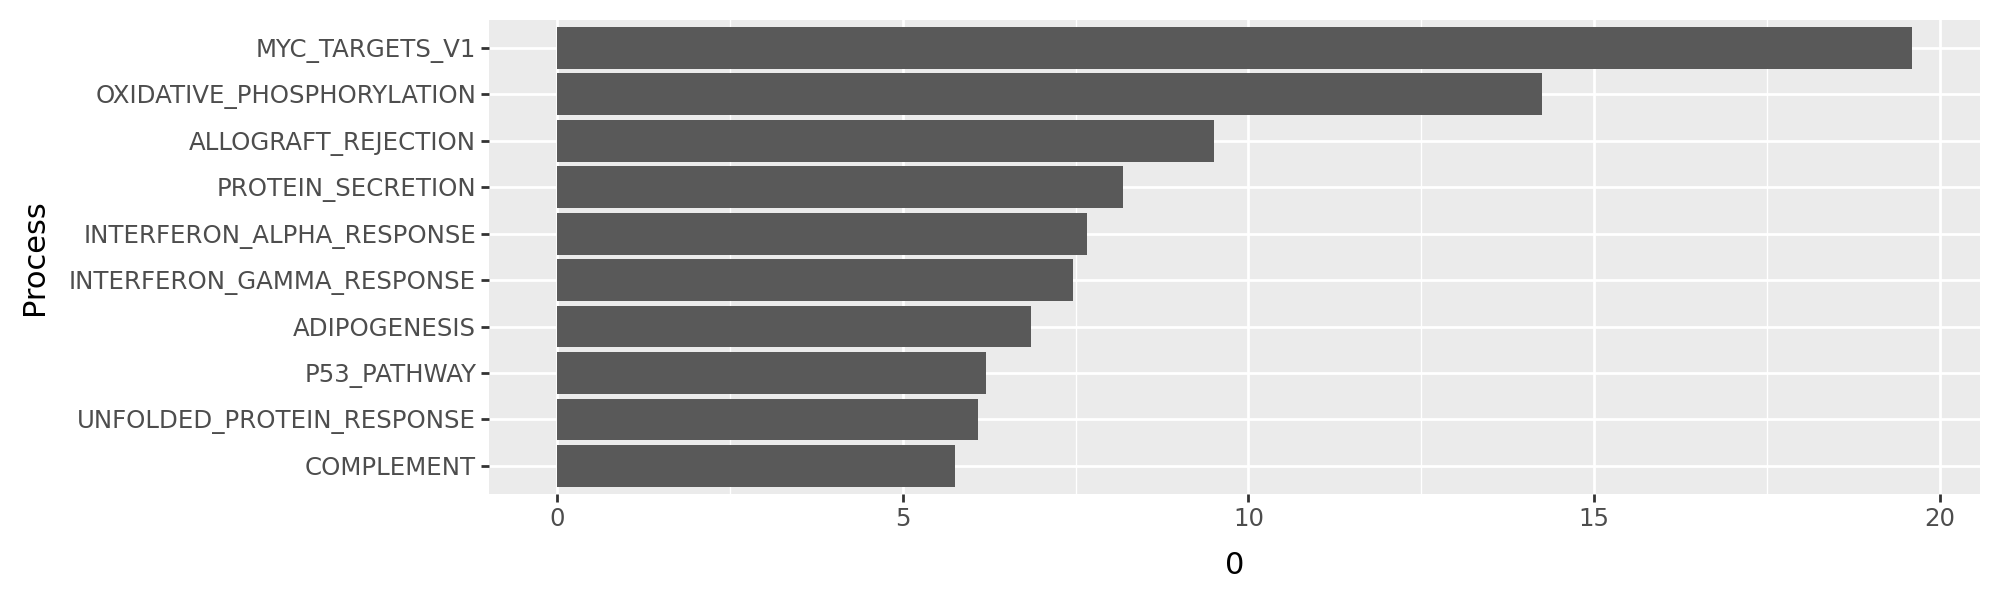

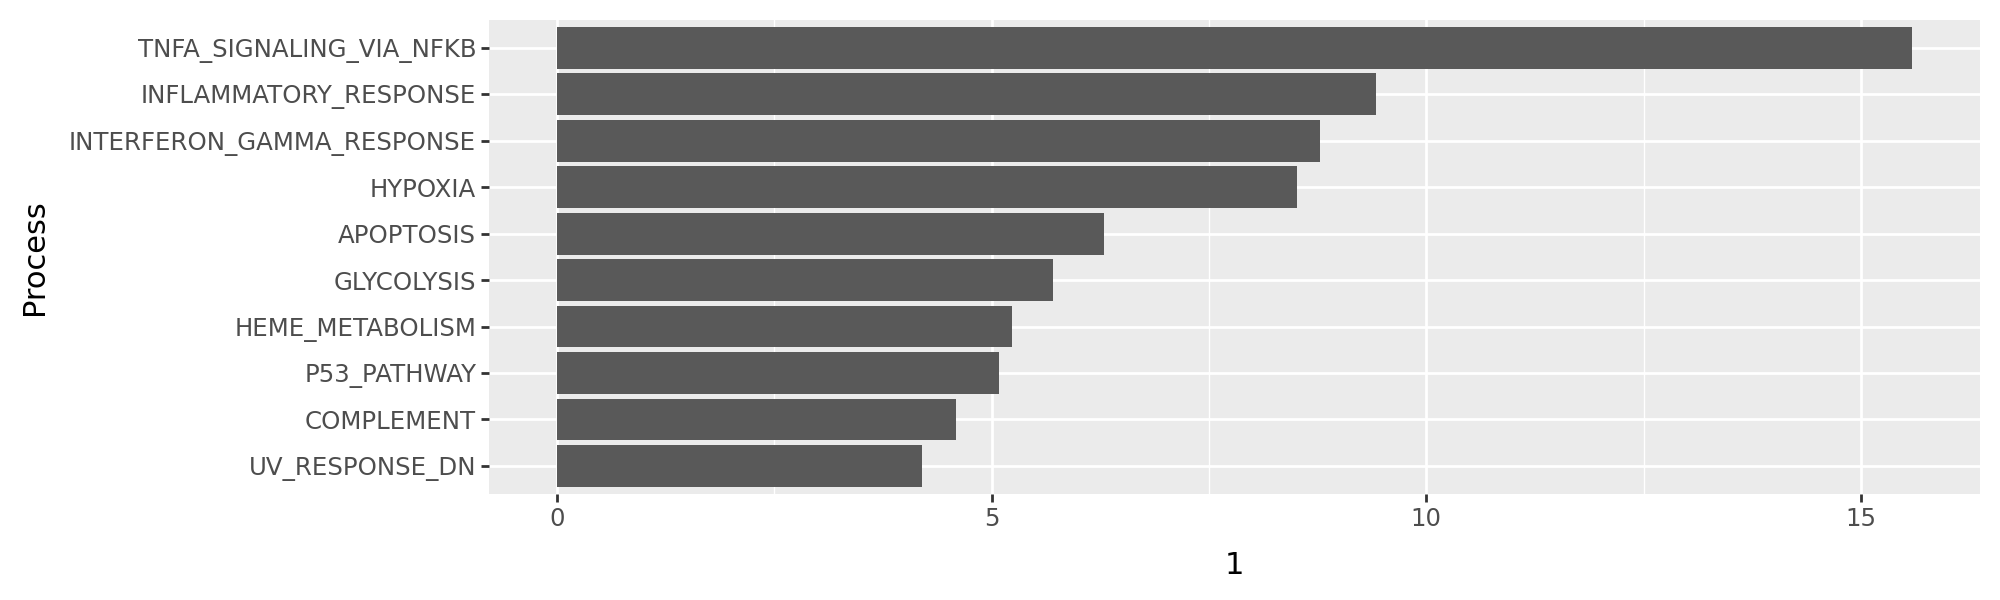

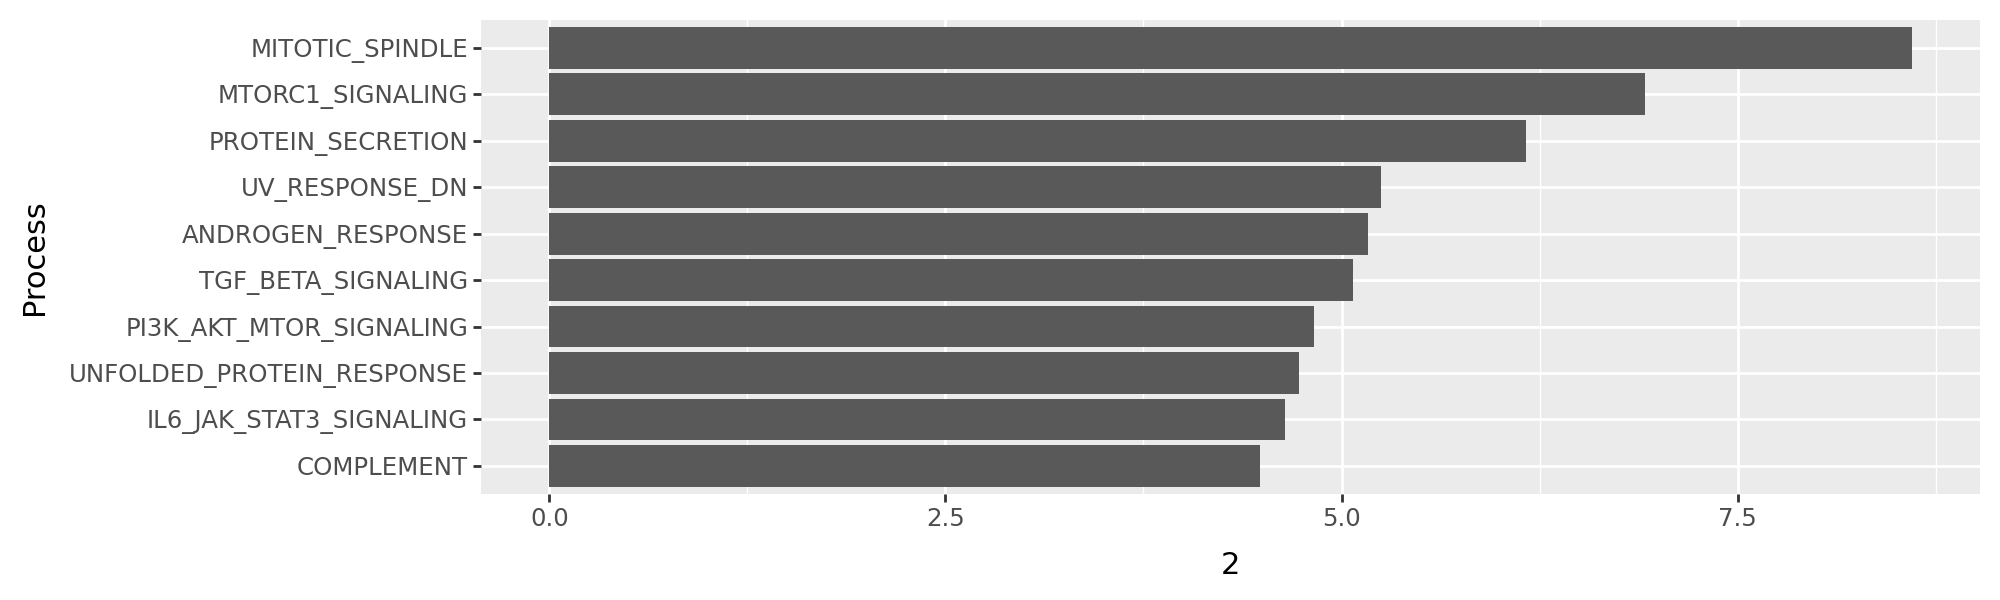

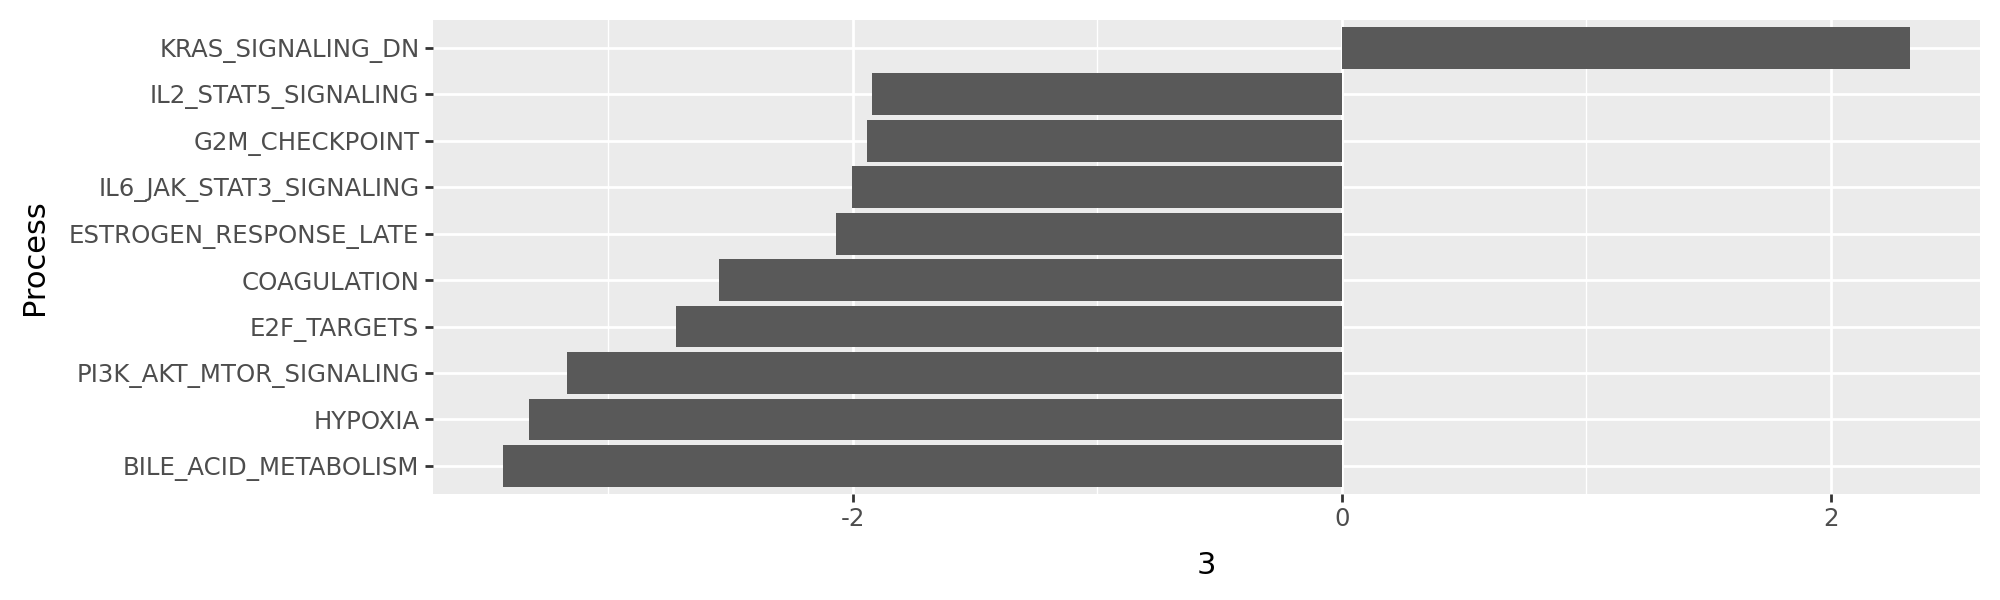

In [14]:
for arch_idx in range(adata.uns["AA_results"]["Z"].shape[0]):
    top_processes[arch_idx]["Process"] = pd.Categorical(
        top_processes[arch_idx]["Process"],
        categories=top_processes[arch_idx].sort_values(f"{arch_idx}", ascending=True)["Process"].to_list()
    )

    p = (pn.ggplot(top_processes[arch_idx])
        + pn.geom_col(pn.aes(x="Process", y=f"{arch_idx}"))
        + pn.coord_flip()
        + pn.theme(figure_size=(10, 3))
        )
    p.show()